In [22]:

# remove these once they're published
!git clone https://github.com/folsomcp/specpolFlow
!git clone https://github.com/folsomcp/LSDpy

fatal: destination path 'specpolFlow' already exists and is not an empty directory.
fatal: destination path 'LSDpy' already exists and is not an empty directory.


# Using SpecPolFlow with Multiple Spectra Files: Example $\xi^1$ CMa (HD 46328)

When a star has multiple observations, it is useful to make a loop over the spectra files rather than running each one individually. To obtain outputs of interest, only one cleaned line mask is necessary since all the spectra files are from the same star. With the cleaned mask and .s files, you must then loop over the `LSDpy.lsdpy.main()` function to calculate outputs for each inputted spectra file.

In the below tutorial, we will be walking you through how to calculate data from multiple spectra files for the same star. It is recomended you first look through the SpecPolTutorial for additional background on individual steps. We have provided three spectra files (hd46328_test_1.s (ObsId: 2378216p), hd46328_test_2.s (ObsId: TKTKTK), and hd46328_test_3.s (ObsId:TKTKTK)) for $\xi^1$ CMa (HD 46328) ([Erba et al. 2021](https://doi.org/10.1093/mnras/stab1454)) and the long list (LongList_T27000G35.dat) from the Vienna Atomic Line Database (VALD) ([Ryabchikova et al. 2015](https://ui.adsabs.harvard.edu/abs/2015PhyS...90e4005R/abstract)).

# Importing Necessary Packages

In [26]:
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.constants as const
import specpolFlow as pol
import LSDpy

import copy
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Creating & Cleaning LSD Line Mask

Below, we specify the name of the VALD long list and the name and location of our created mask. Next, we remove regions 100 km $\text{s}^{-1}$ (specific to this example) around the Balmer series and Balmer gap. 

In [42]:

file_name = 'specpolFlow_tutorialfiles/LongList_T27000G35.dat'
file_output = 'specpolFlow_tutorialfiles/test_output/T27000G35_depth0.02.mask'
mask_file = pol.makeMask.make_mask(file_name, file_output, depthCutoff = 0.02, atomsOnly = True)

clean_mask = 'specpolFlow_tutorialfiles/test_output/hd46328_test_depth0.02_clean.mask'

# user manual for telleric regions
velrange = 100
data = pol.cleanMask.default_exclude_regions(velrange)
pol.cleanMask.clean_model_mask(file_output, clean_mask, data)

missing Lande factors for 160 lines (skipped) from:
['He 2', 'O 2']
skipped all lines for species:
['H 1']
Masks made!
Masks cleaned!


# Create LSD Profile

Here, we create the LSD files for all three spectra file by looping over all three file names.

In [43]:
vsini = 15 #km/s
vradCorrected = 0 #km/s

file = 'specpolFlow_tutorialfiles/hd46328_test_{}.s'
outfile = 'specpolFlow_tutorialfiles/test_output/hd46328_test_{}.lsd'

for i in range(0,3):
    lsdoutput = LSDpy.lsdpy.main(observation = file.format(i+1), mask = clean_mask, outName = outfile.format(i+1), 
            velStart = - 100.0, velEnd = 100.0, velPixel = 2.6, 
            normDepth = 0.2, normLande = 1.2, normWave = 500.0,
            removeContPol = 1, trimMask = 0, sigmaClipIter = 0, sigmaClip = 500, 
            interpMode = 1, fSaveModelS = 0, outModelName = '',
            fLSDPlotImg = 0, fSavePlotImg = 0, outPlotImgName = '')

Average observed spec velocity spacing: 1.808983 km/s
using a 78 point profile with 2.600000 km/s pixels
mean mask depth 0.098182 wl 493.062 Lande 1.181760 (from 1134 lines)
mean mask norm weightI 0.490908 weightV 0.466251
I reduced chi2 494.6215 (chi2 39249203.32 constraints 79430 dof 78)
 Rescaling error bars by: 22.240087
V reduced chi2 1.1313 (chi2 89772.90 constraints 79430 dof 78)
 Rescaling error bars by: 1.063638
 removing profile continuum pol: -7.6311e-06 +/- 7.5898e-09 (avg err 8.6820e-05)
N1 reduced chi2 1.1084 (chi2 87953.46 constraints 79430 dof 78)
 Rescaling error bars by: 1.052804
 removing profile continuum pol: -1.0640e-07 +/- 7.4360e-09 (avg err 8.5935e-05)
(possible Stokes I uncertainty underestimate 2.1030e-03 vs 1.8825e-03)
line range estimate -14.200000000000188 42.99999999999969 km/s
V in line reduced chi^2 75.457637 (chi2 1660.068009) 
 detect prob 1.000000 (fap 0.000000e+00)
 Detection! V (fap 0.000000e+00)
 V outside line reduced chi^2 1.600220 (chi2  80.010

We can also output a .pdf with all the LSD plots for each observation which is useful for ensuring that the LSD profiles look as expected. 

Also note that `%%capture` suppresses the cell's output.

In [44]:
%%capture
with PdfPages('specpolFlow_tutorialfiles/test_output/hd46328_test.pdf') as pdf:

    file = 'specpolFlow_tutorialfiles/hd46328_test_{}.s'
    outfile = 'specpolFlow_tutorialfiles/test_output/hd46328_test_{}.lsd'

    for i in range(0,3):

        lsd = pol.iolsd.read_lsd(outfile.format(i+1))
        fig, ax = plt.subplots(4,1, figsize = (10,10))

        ax[3].errorbar(lsd.vel, lsd.specI, yerr = lsd.specSigI, xerr = None, fmt = 'o', ms = 3,ecolor = '0.5',c = 'k')
        ax[2].errorbar(lsd.vel, lsd.specN1, yerr = lsd.specSigN1, xerr = None, fmt = 'o', ms = 3,ecolor = '0.5',c = 'k')
        ax[1].errorbar(lsd.vel, lsd.specN2, yerr = lsd.specSigN2, xerr = None, fmt = 'o', ms = 3,ecolor = '0.5',c = 'k')
        ax[0].errorbar(lsd.vel, lsd.specV, yerr = lsd.specSigV, xerr = None, fmt = 'o', ms = 3, ecolor = '0.5',c = 'k')
        plt.subplots_adjust(hspace = .0)
        ax[3].set_xlabel('Velocity (km/s)')
        ax[3].set_ylabel('I')
        ax[2].set_ylabel('N1')
        ax[1].set_ylabel('N2')
        ax[0].set_ylabel('V')
        fig.suptitle('HD46328 test' + '-'+ str(i+1),y = 0.92)

        pdf.savefig(fig)


# Bz Calculation

We can then repeat the above steps for the Bz calculation. Note that each observation has a different `vrad`. One method to resolve this is to make a `vrad` array and put that inside the loop as done below. 

using AUTO method for the normalization
  using the median of the continuum outside of the line
using AUTO method for the normalization
  using the median of the continuum outside of the line
using AUTO method for the normalization
  using the median of the continuum outside of the line


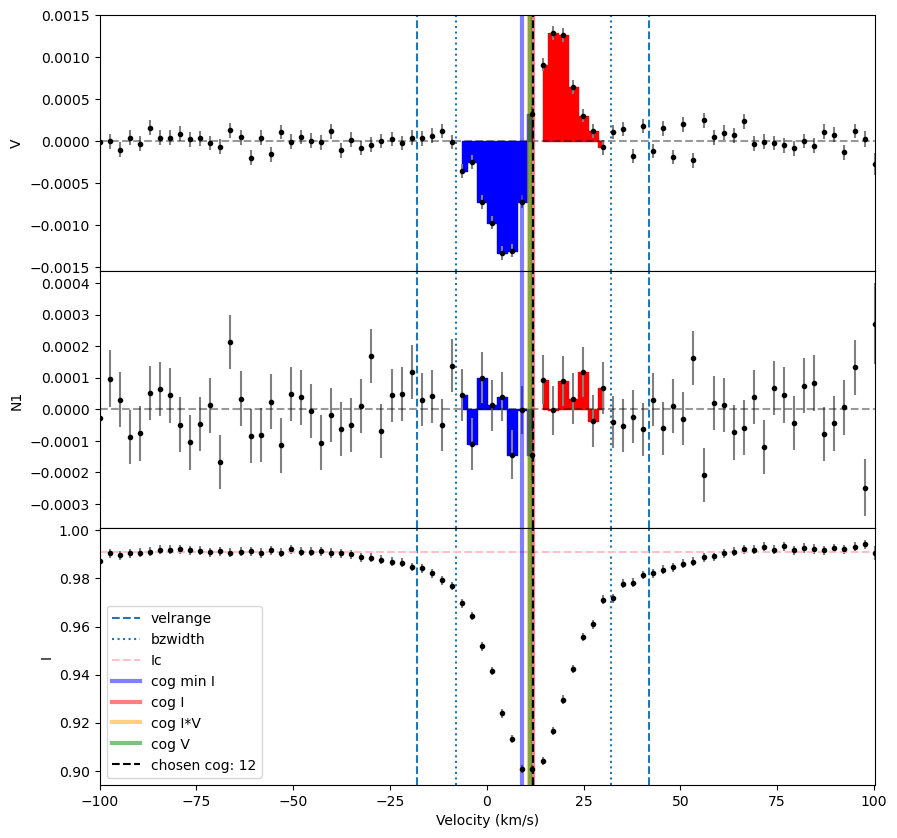

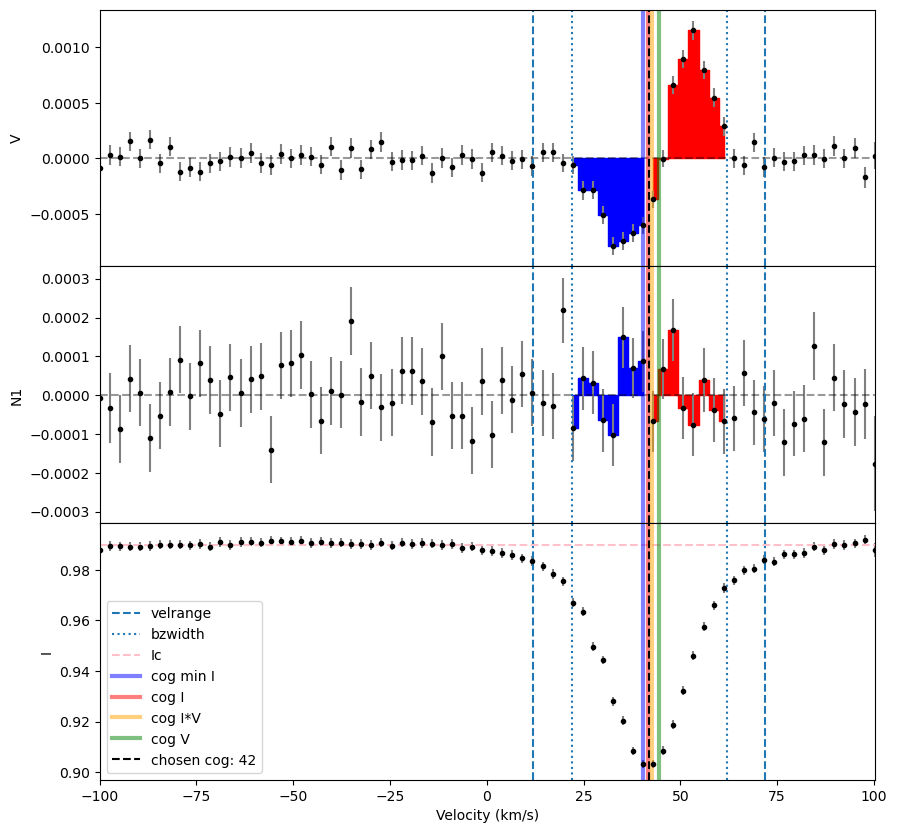

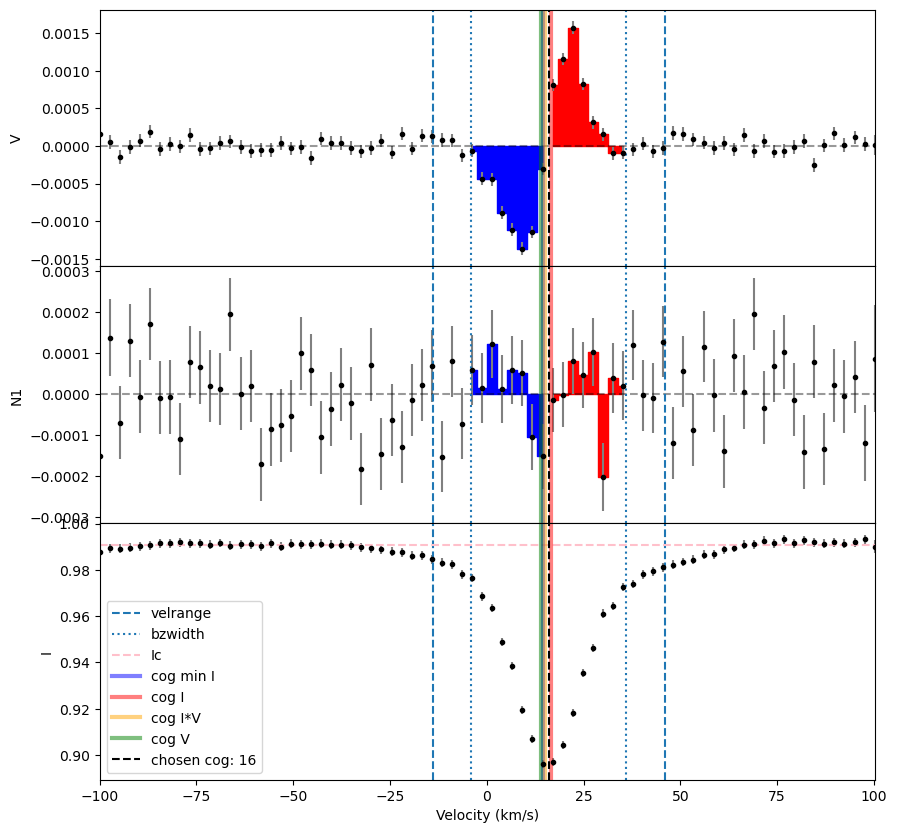

In [45]:
# Bz calculation using manual cog selection
star = 'hd46328'

vsini = 20
vrad = [12,42,16]

for i in range(3):
    lsdpath = 'specpolFlow_tutorialfiles/test_output/hd46328_test_{}.lsd'
    velrange = [vrad[i]-30,vrad[i]+30]
    bzwidth = 20
    lsd = pol.iolsd.read_lsd(lsdpath.format(i+1))
    Bz, fig = pol.bz.calcBz(lsd = lsd, cog = vrad[i], velrange = velrange, plot = True, bzwidth = bzwidth)

using AUTO method for the normalization
  using the median of the continuum outside of the line
using AUTO method for the normalization
  using the median of the continuum outside of the line
using AUTO method for the normalization
  using the median of the continuum outside of the line


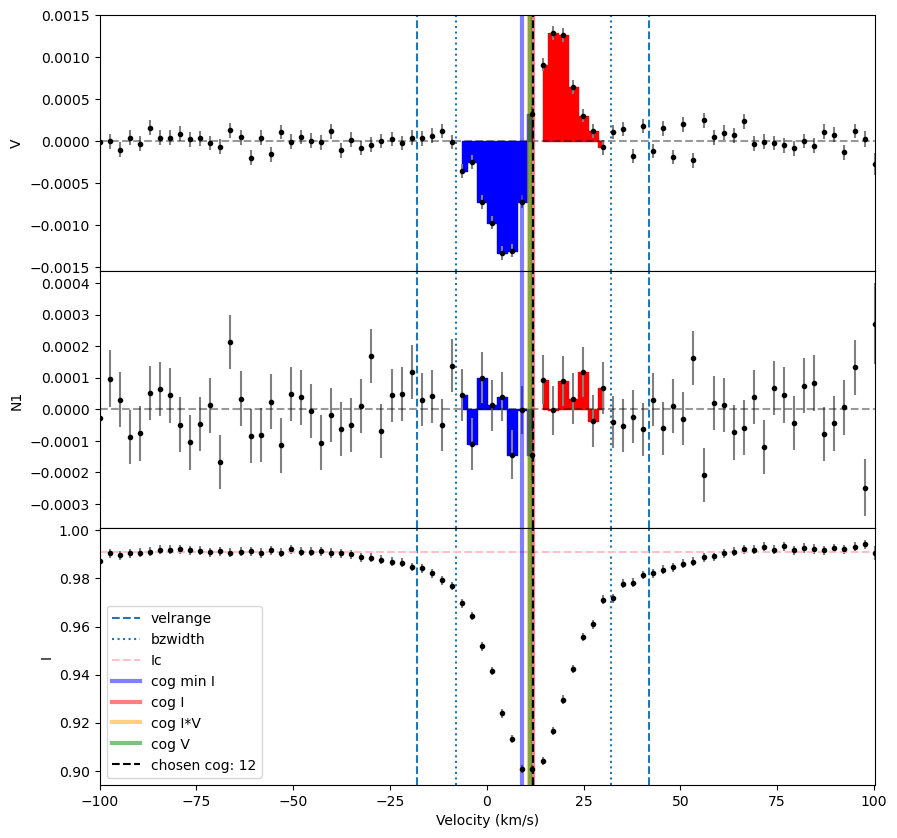

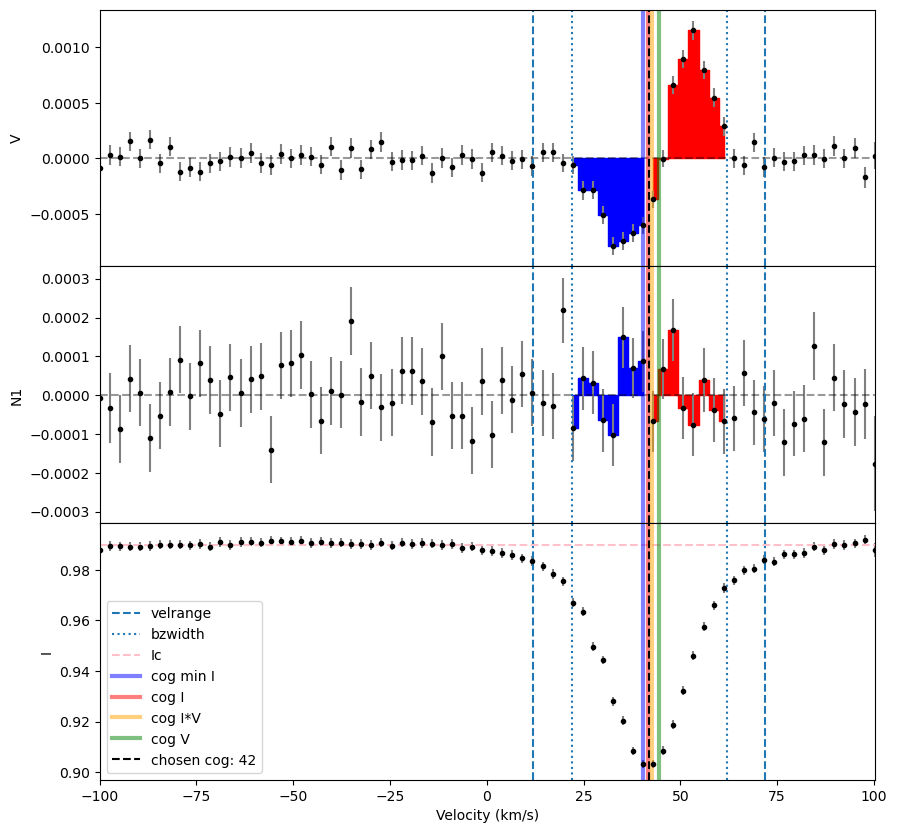

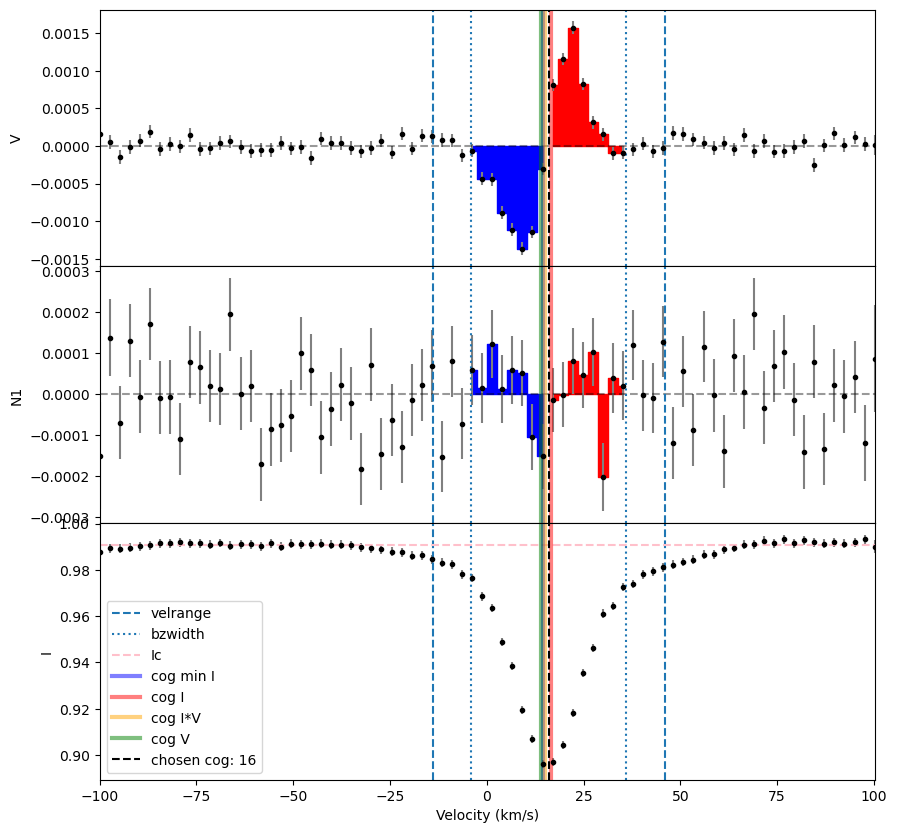

In [46]:
# Bz calculation using manual cog selection
star = 'hd46328'

vsini = 20
vrad = vrad = [12,42,16]
start = 0
for i in range(3):
    lsdpath = 'specpolFlow_tutorialfiles/test_output/hd46328_test_{}.lsd'
    velrange = [vrad[i]-30,vrad[i]+30]
    bzwidth = 20
    lsd = pol.iolsd.read_lsd(lsdpath.format(i+1))
    Bz, fig = pol.bz.calcBz(lsd = lsd, cog = vrad[i], velrange = velrange, plot = True, bzwidth = bzwidth)
    Bz = pd.DataFrame.from_dict(Bz,'index').T
    Bz.insert(0,"Star", star, True)
    if start == 0:
        Bz_table = copy.copy(Bz)
        start = 1
    else:
        Bz_table = pd.concat([Bz_table, Bz], ignore_index = True)



As before, we can also make a .pdf for all the Bz plots.

In [47]:
%%capture
start = 0
with PdfPages('specpolFlow_tutorialfiles/test_output/hd46328_test_Bz.pdf') as pdf:

    # Bz calculation using manual cog selection
    star = 'hd46328'

    vsini = 20
    vrad = vrad = [12,42,16]

    for i in range(3):
        lsdpath = 'specpolFlow_tutorialfiles/test_output/hd46328_test_{}.lsd'
        velrange = [vrad[i]-30,vrad[i]+30]
        bzwidth = 20
        lsd = pol.iolsd.read_lsd(lsdpath.format(i+1))
        Bz, fig = pol.bz.calcBz(lsd = lsd, cog = vrad[i], velrange = velrange, plot = True, bzwidth = bzwidth)
        
        Bz = pd.DataFrame.from_dict(Bz,'index').T
        Bz.insert(0,"Star", star, True)
        if start == 0:
            Bz_table = copy.copy(Bz)
            start = 1
        else:
            Bz_table = pd.concat([Bz_table, Bz], ignore_index = True)
        fig.suptitle('{} - {}'.format(star,i+1),fontsize = 20,y = 0.92)
            
        pdf.savefig(fig)


Often times we also want to output a single table of all the Bz outputs for each observation rather than a different table for each observation. Below is a single output table with the Bz outputs for every observation in the loop.

In [48]:
Bz_table

,Star,Ic,cog,Bzwidth min,Bzwidth max,V bz (G),V bz sig (G),V FAP,N1 bz (G),N1 bz sig (G),N1 FAP,N2 bz (G),N2 bz sig (G),N2 FAP
0,hd46328,0.991048,12.0,-8.0,32.0,-114.107172,5.435434,0.0,-4.670879,5.296219,0.283879,0.0,0.0,0.0
1,hd46328,0.989802,42.0,22.0,62.0,-114.641551,5.777110,0.0,1.050306,5.657893,0.297656,0.0,0.0,0.0
2,hd46328,0.990911,16.0,-4.0,36.0,-109.533818,6.028898,0.0,4.263937,5.852640,0.272028,0.0,0.0,0.0
